In [1]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

ResNet50

In [3]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Check Image Corruption

In [8]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [9]:
def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        
        # Quality enhancement
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness
        
        # Noise reduction
        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Consistency
        img = img.resize(size, Image.LANCZOS)

        # Normalization
        img_array = np.array(img) / 255.0
    
        # Convert back to image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error processing image {image_path}: {e}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [10]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [11]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(21, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_ResNet_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='max',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 1558s 5s/step - accuracy: 0.6579 - loss: 1.1613 - val_accuracy: 0.0543 - val_loss: 5.6862
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1535s 5s/step - accuracy: 0.9067 - loss: 0.2881 - val_accuracy: 0.4343 - val_loss: 2.2486
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1541s 5s/step - accuracy: 0.9395 - loss: 0.1910 - val_accuracy: 0.9305 - val_loss: 0.2182
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1535s 5s/step - accuracy: 0.9469 - loss: 0.1705 - val_accuracy: 0.9648 - val_loss: 0.1050
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1517s 5s/step - accuracy: 0.9555 - loss: 0.1358 - val_accuracy: 0.9714 - val_loss: 0.0940
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1518s 5s/step - accuracy: 0.9628 - loss: 0.1089 - val_accuracy: 0.9476 - val_loss: 0.2126
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1520s 5s/step - accuracy: 0.9566 - loss: 0.1307 - val_accuracy: 0.9800 - val_loss: 0.0680
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 1524s 5s/step - accuracy: 0.9674 - loss: 0.0959 - val_accurac

In [13]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

329/329 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.9748 - loss: 0.1139


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9753 - loss: 0.1193
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 972ms/step - accuracy: 0.9518 - loss: 0.2246
Train accuracy: 0.9749, Validation accuracy: 0.9652, Test accuracy: 0.9619


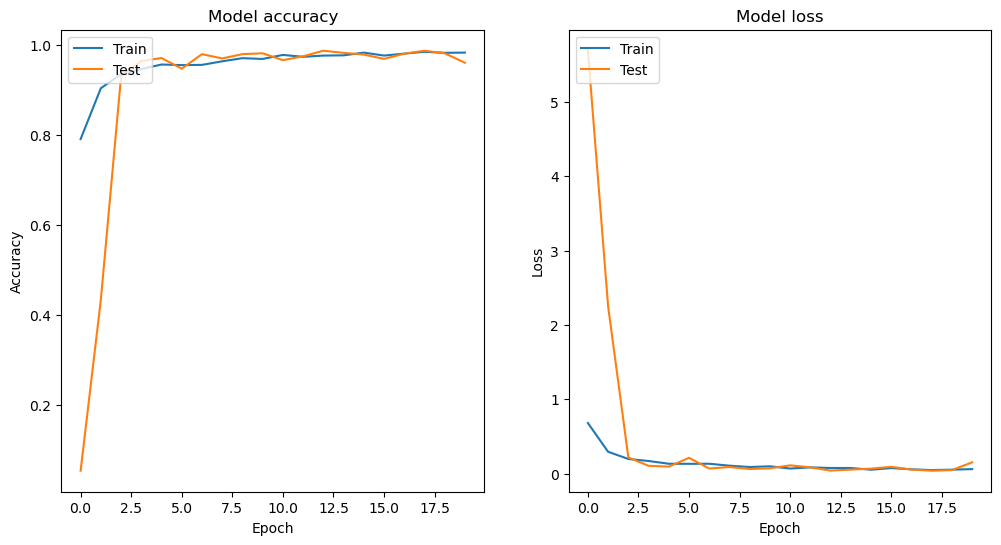

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

test_generator.reset()
Y_pred = model.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step
                   precision    recall  f1-score   support

     agricultural       0.05      0.06      0.06        50
         airplane       0.04      0.04      0.04        50
  baseballdiamond       0.08      0.08      0.08        50
            beach       0.08      0.08      0.08        50
        buildings       0.05      0.06      0.05        50
        chaparral       0.03      0.02      0.02        50
 denseresidential       0.07      0.06      0.06        50
           forest       0.11      0.10      0.10        50
          freeway       0.06      0.06      0.06        50
       golfcourse       0.08      0.08      0.08        50
           harbor       0.08      0.08      0.08        50
     intersection       0.04      0.04      0.04        50
mediumresidential       0.08      0.08      0.08        50
   mobilehomepark       0.04      0.04      0.04        50
         overpass       0.08      0.08      0.08        50
       parkinglo